<a href="https://colab.research.google.com/github/gorogoro-uk/TensorFlow/blob/master/TF_4_1_TimeSeries_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TensorFlow 4.1: Time Series**

2.2.0


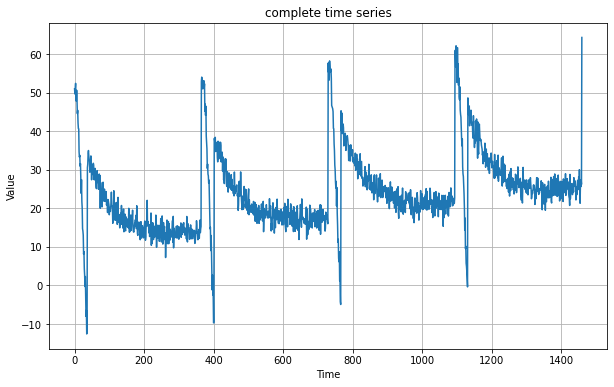

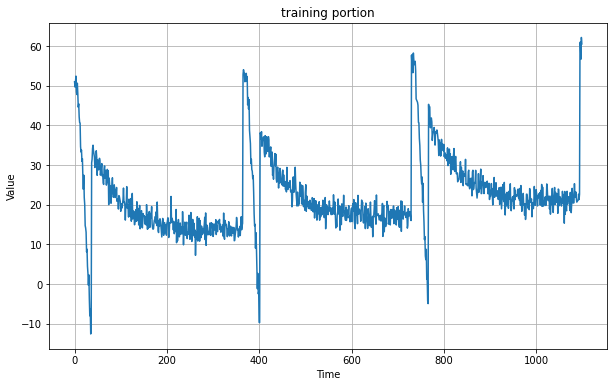

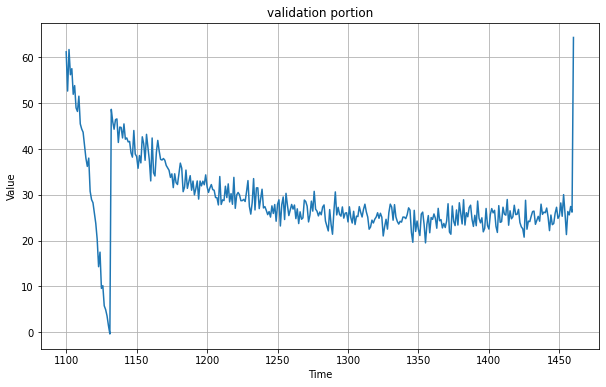

In [ ]:
# import code
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# plot time series
def plot_series(time, series, format="-", start=0, end=None):
    """plot a series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# linear trend
def trend(time, slope=0):
    """simple linear trend"""
    return slope * time

# recurring seasonal pattern
def seasonal_pattern(season_time):
    """periodic pattern to repeat each season:
      cos wave in first 10% of period,
      decaying exponential in remainder of period"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

# seasonality
def seasonality(time, period, amplitude=1, phase=0):
    """create mulitple periods of seasonal data"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# random noise simulator
def noise(time, noise_level=1, seed=None):
    """random noise"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# timebase vector
# daily over 4 year period
time = np.arange(4 * 365 + 1, dtype="float32")

# parameters
baseline = 10
#series = trend(time, 0.1)
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

# plot complete time series
plt.figure(figsize=(10, 6))
plt.title('complete time series')
plot_series(time, series)
plt.show()

# train, test datasets
split_time = 1100     
time_train = time[:split_time]    # first 3 years
x_train = series[:split_time]
time_valid = time[split_time:]     # last 1 year
x_valid = series[split_time:]

# plot train, test
plt.figure(figsize=(10, 6))
plt.title('training portion')
plot_series(time_train, x_train)
plt.show()
plt.figure(figsize=(10, 6))
plt.title('validation portion')
plot_series(time_valid, x_valid)
plt.show()

19.578304
2.6011968


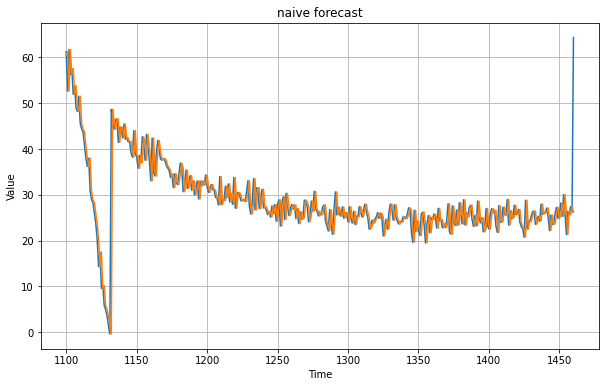

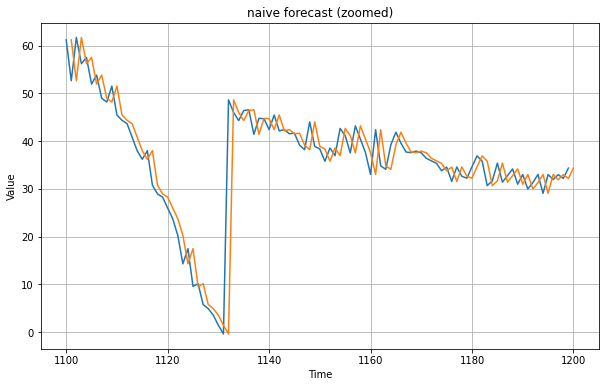

In [ ]:
# 1. naive forecast: next = previous
ma = 1
naive_forecast = series[split_time - ma:-ma]

plt.figure(figsize=(10, 6))
plt.title('naive forecast')
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

plt.figure(figsize=(10, 6))
plt.title('naive forecast (zoomed)')
plot_series(time_valid, x_valid, start=0, end=100)
plot_series(time_valid, naive_forecast, start=ma, end=100+ma)   # shift left to coincide

# error: MSE & MAE
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

65.786224
4.3040023


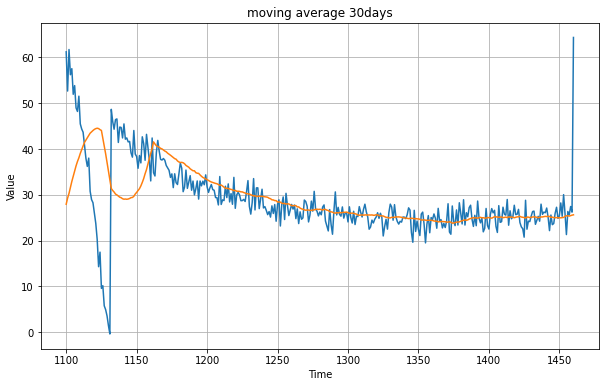

In [ ]:
# 2. normal moving average: window = 30

# general moving average function
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

ma = 30
moving_avg = moving_average_forecast(series, ma)[split_time - ma:]

plt.figure(figsize=(10, 6))
plt.title('moving average 30days')
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

# errors
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())    # MSE
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())   # MAE

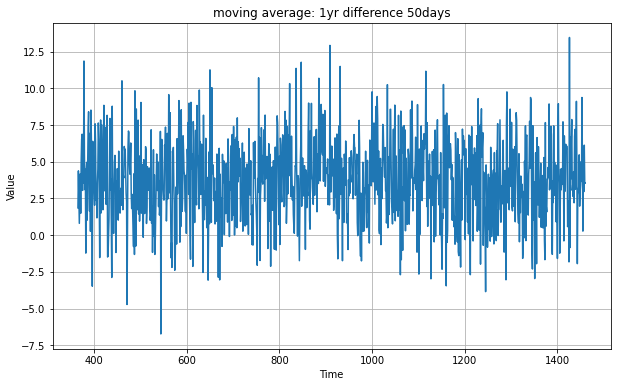

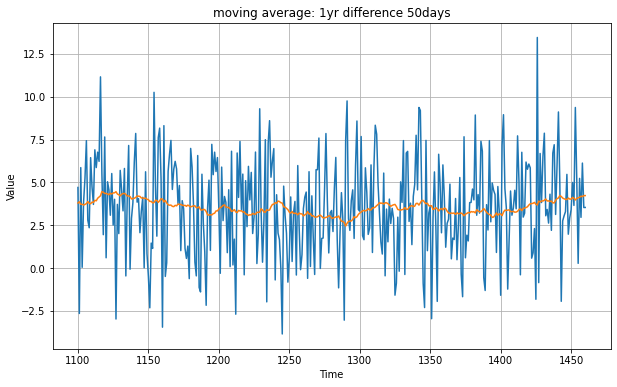

In [ ]:
# 3. moving average different series
diff_ma = 50
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plt.title('moving average: 1yr difference 50days')
plot_series(diff_time, diff_series)
plt.show()

diff_moving_avg = moving_average_forecast(diff_series, diff_ma)[split_time - 365 - diff_ma:]

plt.figure(figsize=(10, 6))
plt.title('moving average: 1yr difference 50days')
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

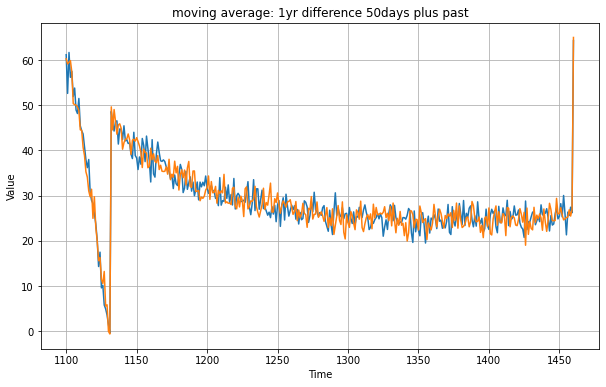

8.498155
2.327179


In [ ]:
# 4. moving average plus past
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plt.title('moving average: 1yr difference 50days plus past')
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

# errors
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

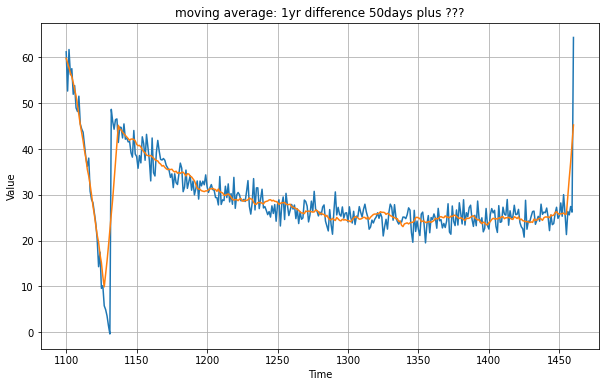

12.527958
2.2034433


In [ ]:
# 5. moving average with smoothing
past_ma = 10    # moving average window to smooth past
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 360 - past_ma:-360], past_ma) + diff_moving_avg

plt.figure(figsize=(10, 6))
plt.title('moving average: smoothed past and smotthed differenced')
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())